In [1]:
import tensorflow as tf
import numpy as np
import os
root_dir = '../'
from sys import path; path.append(root_dir)
import matplotlib.pyplot as plt
%matplotlib inline

/Users/evariste/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from dataset import AutoDLDataset
from dataset import AutoDLMetadata

path_to_data = "/Users/evariste/projects/autodl/codalab_competition_bundle/AutoDL_input_data_1/mnist1/train"

dataset_name = "mnist"
data_set = AutoDLDataset(path_to_data)
data_set.init()

In [30]:
metadata = data_set.get_metadata()

In [31]:
def print_metadata_info(metadata):
    bundle_size = metadata.get_bundle_size()
    print("Number of bundles: ", bundle_size)
    print("Output size: ", metadata.get_output_size())
    print("Sequence size: ", metadata.get_sequence_size())
    for bundle_index in range(bundle_size):
        print("Info on Bundle #", bundle_index, ": ")
        if metadata.is_compressed(bundle_index):
            print("  Bundle format: COMPRESSED")
        elif metadata.is_sparse(bundle_index):
            print("  Bundle format: SPARSE")
        else:
            print("  Bundle format: DENSE")
        print("  Matrix size: ", metadata.get_matrix_size(bundle_index))

In [191]:
print_metadata_info(metadata)

Number of bundles:  1
Output size:  10
Sequence size:  1
Info on Bundle # 0 : 
  Bundle format: DENSE
  Matrix size:  (28, 28)


In [5]:
dataset = data_set.get_dataset()

In [14]:
iterator = dataset.make_one_shot_iterator()

In [15]:
next_example, next_label = iterator.get_next()

In [16]:
dataset

<RepeatDataset shapes: ((?, 1, ?, ?), (?, 10)), types: (tf.float32, tf.float32)>

In [282]:
type(tf.VarLenFeature(tf.float32))

tensorflow.python.ops.parsing_ops.VarLenFeature

In [43]:
next_label.shape

TensorShape([Dimension(None), Dimension(10)])

In [45]:
logits.shape

TensorShape([Dimension(None), Dimension(10)])

In [46]:
next_label.shape

TensorShape([Dimension(None), Dimension(None), Dimension(10)])

In [63]:
next_label.shape

TensorShape([Dimension(None), Dimension(10)])

In [25]:
dataset

<RepeatDataset shapes: ((?, 1, ?, ?), (?, 10)), types: (tf.float32, tf.float32)>

In [58]:
num_epochs = 10
col_count = 28
row_count = 28
sequence_size = 1
output_dim = 10

dataset = data_set.get_dataset()
# dataset = dataset.shuffle(buffer_size=10000)
dataset = dataset.repeat(num_epochs)
iterator = dataset.make_one_shot_iterator()

next_example, next_label = iterator.get_next()
# next_example_flat = tf.layers.flatten(next_example)
next_example_flat = tf.reshape(next_example, [-1, col_count*row_count*sequence_size])
example_flatten = tf.layers.flatten(next_example)

logits = tf.layers.dense(inputs=next_example_flat, units=output_dim)

loss = tf.losses.softmax_cross_entropy(onehot_labels=next_label, logits=logits)

training_op = tf.train.AdagradOptimizer(learning_rate=0.1).minimize(loss)

predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

In [87]:
num_epochs = 10
col_count = 28
row_count = 28
sequence_size = 1
output_dim = 10
batch_size = 30

from dataset import AutoDLDataset
from dataset import AutoDLMetadata

def model_fn(features, labels, mode):
  input_layer = tf.reshape(features['x'], 
                           [-1, sequence_size*row_count*col_count])
  print("#"*50, "model_fn", mode, input_layer.shape)
  logits = tf.layers.dense(inputs=input_layer, units=output_dim)
  
  predictions = {
    # Generate predictions (for PREDICT and EVAL mode)
    "classes": tf.argmax(input=logits, axis=1),
    # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
    # `logging_hook`.
    "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  assert mode == tf.estimator.ModeKeys.EVAL
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

def main(unused_argv):
  
  # Create the Estimator
  classifier = tf.estimator.Estimator(model_fn=model_fn)

  # Set up logging for predictions
  # Log the values in the "Softmax" tensor with label "probabilities"
  tensors_to_log = {"probabilities": "softmax_tensor"}
  logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=50)
  
  path_to_train_data = "/Users/evariste/projects/autodl/" +\
    "codalab_competition_bundle/AutoDL_input_data_1/mnist1/train"

  train_data_set = AutoDLDataset(path_to_train_data)
  train_data_set.init()
  dataset = train_data_set.get_dataset()
  train_dataset_dict = dataset.map(lambda x, y: ({'x': x}, y))
  
  # Train the model
  def train_input_fn():
    iterator = train_dataset_dict.make_one_shot_iterator()
    features, labels = iterator.get_next()
    return features, labels
    
  classifier.train(
      input_fn=train_input_fn,
      steps=200)#,
      # hooks=[logging_hook])
  
  print("*"*50, "Begin evaluation!")
  # Evaluate the model and print results
#   eval_input_fn = tf.estimator.inputs.numpy_input_fn(
#       x={"x": eval_data},
#       y=eval_labels,
#       num_epochs=1,
#       shuffle=False)
#   eval_results = classifier.evaluate(input_fn=eval_input_fn)
#   print(eval_results)
  path_to_test_data = "/Users/evariste/projects/autodl/" +\
    "codalab_competition_bundle/AutoDL_input_data_1/mnist1/test"
  test_data_set = AutoDLDataset(path_to_test_data)
  test_data_set.init(batch_size=1000, repeat=False)
  dataset = test_data_set.get_dataset()
  test_dataset_dict = dataset.map(lambda x, y: ({'x': x}, y))
  
  def test_input_fn():
    iterator = test_dataset_dict.make_one_shot_iterator()
    features, labels = iterator.get_next()
    return features, labels
  
  res = []
  test_results = classifier.predict(input_fn=test_input_fn)
  res = [x['probabilities'] for x in test_results]
  res = np.array(res)
  print(res.shape)
  
  

if __name__ == "__main__":
  tf.app.run()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/g_/rs9p7mjx0c10qk25vqkmmw380000gn/T/tmp4dswpfb8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c2255fc50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Number of training files: 7.
INFO:tensorflow:Calling model_fn.
################################################## model_fn train (?, 784)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorf

SystemExit: 

/Users/evariste/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
train_input_fn = 

In [61]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.RepeatDataset

In [46]:
tf.logging.set_verbosity(tf.logging.INFO)
tf.app.run(main)

NameError: name 'parser' is not defined

In [174]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Compute for 100 epochs.
for _ in range(100):
  sess.run(iterator.initializer)
  while True:
    try:
      sess.run(next_element)
    except tf.errors.OutOfRangeError:
      break

RuntimeError: Attempted to use a closed Session.

### With Estimator

In [80]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-

In [84]:
mnist

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1c22c10e10>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x18215ce630>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1c22c10a90>)

In [83]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.RepeatDataset

In [99]:
haha = tf.data.Dataset.from_tensor_slices(np.random.uniform(size=(4,10)))

In [101]:
type(haha)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [105]:
haha = haha.repeat()

In [107]:
type(data_set.get_dataset())

tensorflow.python.data.ops.dataset_ops.RepeatDataset

In [111]:
dataset

<RepeatDataset shapes: ((?, 1, ?, ?), (?, 10)), types: (tf.float32, tf.float32)>

In [110]:
help(tf.data.Dataset)

Help on class Dataset in module tensorflow.python.data.ops.dataset_ops:

class Dataset(builtins.object)
 |  Represents a potentially large set of elements.
 |  
 |  A `Dataset` can be used to represent an input pipeline as a
 |  collection of elements (nested structures of tensors) and a "logical
 |  plan" of transformations that act on those elements.
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  apply(self, transformation_func)
 |      Apply a transformation function to this dataset.
 |      
 |      `apply` enables chaining of custom `Dataset` transformations, which are
 |      represented as functions that take one `Dataset` argument and return a
 |      transformed `Dataset`.
 |      
 |      For example:
 |      
 |      ```
 |      dataset = (dataset.map(lambda x: x ** 2)
 |                 .apply(group_by_window(key_func, reduce_func, windo

In [116]:
dataset.

(tf.float32, tf.float32)

### Exploring raw data

In [56]:
files = tf.gfile.Glob(os.path.join("", "mnist", "sample*"))
dataset_ = tf.data.TFRecordDataset(files)

In [57]:
type(dataset_)

tensorflow.python.data.ops.readers.TFRecordDataset

In [58]:
dataset_

<TFRecordDataset shapes: (), types: tf.string>

In [62]:
sequence_features = {"0_dense_input": tf.FixedLenSequenceFeature((28,28), dtype=tf.float32)}

In [63]:
contexts, features = tf.parse_single_sequence_example(
        dataset_,
        context_features={
            "label_index": tf.VarLenFeature(tf.int64),
            "label_score": tf.VarLenFeature(tf.float32)
        },
        sequence_features=sequence_features)

TypeError: Expected string passed to parameter 'serialized' of op 'ParseSingleSequenceExample', got <TFRecordDataset shapes: (), types: tf.string> of type 'TFRecordDataset' instead.

In [134]:
it = dataset_.make_one_shot_iterator()

In [151]:
with tf.Session() as sess:
    haha = sess.run(iterator.get_next())
    print(type(haha[0]))
    print(haha[0].shape)
    print(haha[1].shape)

<class 'numpy.ndarray'>
(30, 1, 28, 28)
(30, 10)


In [161]:
with tf.Session() as sess:
    haha = sess.run(example_flatten)
    print(type(haha[0]))
    print(haha.shape)
    print(haha[1].shape)

<class 'numpy.ndarray'>
(30, 784)
(784,)


In [153]:
mnist.train.images.shape

(55000, 784)

In [155]:
mnist.train.labels.shape

(55000,)

In [158]:
mnist.test.images.shape

(10000, 784)

In [169]:
for _ in range(100):
  while True:
    try:
      sess.run(next_example)
    except tf.errors.OutOfRangeError:
      break

RuntimeError: Attempted to use a closed Session.

### Convert MNIST to TFRecords

In [ ]:
%load /Users/evariste/projects/code-exercises/tensorflow/convert_to_records.py

In [ ]:
tf.train.SequenceExample()

In [178]:
mnist.DataSet

module

In [250]:
from tensorflow.contrib.learn.python.learn.datasets import mnist

In [182]:
data_sets = mnist.read_data_sets(FLAGS.directory,
                                   dtype=tf.uint8,
                                   reshape=False,
                                   validation_size=FLAGS.validation_size)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [186]:
data_sets.train.images.shape

(55000, 28, 28, 1)

In [198]:
data_sets.train.next_batch()

TypeError: next_batch() missing 1 required positional argument: 'batch_size'

In [200]:
filename = '/tmp/data/train.tfrecords'

In [205]:
haha = tf.data.TFRecordDataset(filename)

In [202]:
examples = haha.

<TFRecordDataset shapes: (), types: tf.string>

In [203]:
contexts, features = tf.parse_single_sequence_example(haha)

ValueError: Missing features.

In [204]:
features=tf.train.Features(
              feature={
                  'height': _int64_feature(rows),
                  'width': _int64_feature(cols),
                  'depth': _int64_feature(depth),
                  'label': _int64_feature(int(labels[index])),
                  'image_raw': _bytes_feature(image_raw)
              })

NameError: name 'rows' is not defined

In [209]:
train_filename = 'train.tfrecords'  # address to save the TFRecords file

# open the TFRecords file
writer = tf.python_io.TFRecordWriter(train_filename)

for i in range(len(train_addrs)):
    # print how many images are saved every 1000 images
    if not i % 1000:
        print('Train data: {}/{}'.format(i, len(train_addrs)))
        sys.stdout.flush()

    # Load the image
    img = load_image(train_addrs[i])

    label = train_labels[i]

    # Create a feature
    feature = {'train/label': _int64_feature(label),
               'train/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}

    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
writer.close()
sys.stdout.flush()

NameError: name 'train_addrs' is not defined

In [ ]:
tf.train.Features()

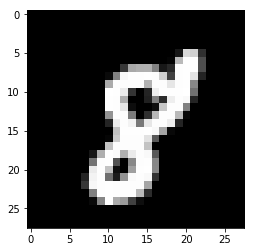

In [246]:
index = np.random.choice(len(data_sets.train.images))
image = data_sets.train.images[index].reshape((28,28))

fig = plt.gca()
fig.imshow(image, cmap='gray')

In [ ]:
def plot_image(image):
    

In [215]:
data_sets.train.images[0].shape

(28, 28, 1)

In [252]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [255]:
cifar10 = tf.contrib.learn.datasets.load_dataset("cifar")

ValueError: Name of dataset is not found: cifar

In [248]:
type(mnist)

tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [256]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import numpy as np
import math
import matplotlib.pyplot as plt
import os


def read_and_decode(filename_queue):
  reader = tf.TFRecordReader()
  _, serialized_example = reader.read(filename_queue)
  features = tf.parse_single_sequence_example(
          serialized_example,
          context_features={
              'label_index': tf.FixedLenFeature(shape=[1], dtype=tf.int64),
              'label_score': tf.FixedLenFeature(shape=[1], dtype=tf.float32)},
          sequence_features={
              '0_dense_input': tf.FixedLenSequenceFeature(
                  shape=[28*28], dtype=tf.float32)}) #image in MNIST is of size 28 by 28
  # print ('features: ', features)

  return features[1]['0_dense_input'], features[0]['label_index']


def read_inputs(inputfile_pattern, batch_size=1000): 
  """
  Arguments: 
  - inputfile_pattern: path to the input tfrecord file
  - batch_size: specify how many images the reader will read

  Returns:
  - dense_inputs_flatten: normalized flatten image matrix, of shape (784, batch_size)
  - one_hot_labels: one-hotted labels
  - labels: raw labels

  Raise:
  IOError
  """
  if not os.path.isfile(inputfile_pattern):
    raise IOError("Unable to find training files. inputfile_pattern='" +
                    inputfile_pattern + "'.")
  filename_queue = tf.train.string_input_producer([inputfile_pattern])

  dense_input, label = read_and_decode(filename_queue)
  
  dense_input = tf.reshape(dense_input, [1, 28*28])
  label = tf.reshape(label, [1, ])
  
  _batch_size = batch_size
  dense_inputs, labels = tf.train.shuffle_batch(
          [dense_input, label], batch_size=_batch_size,
          capacity=1 + 3*_batch_size, min_after_dequeue=1)
  dense_inputs_flatten = tf.transpose(tf.squeeze(dense_inputs))

  dense_inputs_flatten /= 255.
  one_hot_labels = tf.transpose(tf.squeeze(tf.one_hot(labels, 10))) 
  return dense_inputs_flatten, one_hot_labels, labels

In [257]:
filename

'/tmp/data/train.tfrecords'

In [258]:
dense_input, label = read_and_decode(filename)

AttributeError: 'str' object has no attribute 'queue_ref'

In [259]:
filename_queue = tf.train.string_input_producer(["file0.csv", "file1.csv"])

In [260]:
filename_queue

In [261]:
reader = tf.TextLineReader()
key, value = reader.read(filename_queue)

In [262]:
key

<tf.Tensor 'ReaderReadV2:0' shape=() dtype=string>

In [ ]:
tf.train.SequenceExample()

In [ ]:
tf.parse_single_sequence_example()

In [263]:
haha = tf.VarLenFeature(tf.float32)

In [266]:
haha

VarLenFeature(dtype=tf.float32)

In [269]:
metadata_ = AutoDLMetadata("mnist")

In [272]:
def _feature_key(index, feature_name):
    return str(index) + "_" + feature_name

In [277]:
def dataset_file_pattern(dataset_name):
  return os.path.join("", dataset_name, "sample*")

In [278]:
files = tf.gfile.Glob(dataset_file_pattern("mnist"))
sequence_example_proto = tf.data.TFRecordDataset(files)

<TFRecordDataset shapes: (), types: tf.string>

In [279]:
sequence_features = {}
for i in range(metadata_.get_bundle_size()):
  if metadata_.is_sparse(i):
    sequence_features[_feature_key(
        i, "sparse_col_index")] = tf.VarLenFeature(tf.int64)
    sequence_features[_feature_key(
        i, "sparse_row_index")] = tf.VarLenFeature(tf.int64)
    sequence_features[_feature_key(
        i, "sparse_value")] = tf.VarLenFeature(tf.float32)
  if metadata_.is_compressed(i):
    sequence_features[_feature_key(
        i, "compressed")] = tf.VarLenFeature(tf.string)
  else:
    sequence_features[_feature_key(
        i, "dense_input")] = tf.FixedLenSequenceFeature(
            metadata_.get_matrix_size(i), dtype=tf.float32)
contexts, features = tf.parse_single_sequence_example(
    sequence_example_proto,
    context_features={
        "label_index": tf.VarLenFeature(tf.int64),
        "label_score": tf.VarLenFeature(tf.float32)
    },
    sequence_features=sequence_features)

TypeError: Expected string passed to parameter 'serialized' of op 'ParseSingleSequenceExample', got <TFRecordDataset shapes: (), types: tf.string> of type 'TFRecordDataset' instead.

In [289]:
from tensorflow.contrib.learn.python.learn.datasets import mnist

In [291]:
dataset = mnist.read_data_sets()

TypeError: read_data_sets() missing 1 required positional argument: 'train_dir'

In [3]:
filename = 'mnist/sample-00000-of-00007'

In [4]:
haha = tf.data.TFRecordDataset(filenames=[filename])

In [5]:
d = AutoDLDataset('mnist')

In [6]:
d.init()

################################################## ['mnist/sample-00002-of-00007', 'mnist/sample-00003-of-00007', 'mnist/sample-00005-of-00007', 'mnist/sample-00004-of-00007', 'mnist/sample-00001-of-00007', 'mnist/sample-00000-of-00007', 'mnist/sample-00006-of-00007']
INFO:tensorflow:Number of training files: 7.
************************************************** <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>


In [64]:
hahaha = haha.map(d._parse_function)

************************************************** <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>


In [65]:
iterator = hahaha.make_one_shot_iterator()

In [9]:
sess = tf.Session()
num = -1
while True:
    try:
        example = sess.run(iterator.get_next())
        os.sys('cls')
        num += 1
#         print('Example', example)
        print(num)
    except:
        print("End of file!")
        break

End of file!


In [24]:
dataset_iterator = hahaha.make_one_shot_iterator()

inputs = []
outputs = []

with tf.Session() as sess:
  iterator = dataset_iterator.get_next()
  # We add a limited number of examples.
  for _ in range(1000000):
    try:
      input_minibatch, output_minibatch = sess.run(iterator)
    except:
      print("End of file!")
      break
    for inp in input_minibatch:
      # We flatten examples.
      inputs.append(inp)
      outputs.append(output_minibatch)
      

End of file!


In [23]:
inputs[0].shape

(28, 28)

In [29]:
outputs[0].shape

(10,)

### Download and convert MNIST

In [1]:
from tensorflow.contrib.learn.python.learn.datasets import mnist

/Users/evariste/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [6]:
datasets = mnist.read_data_sets(train_dir='/tmp/data/', one_hot=False, validation_size=0)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [10]:
print(datasets.train.images.shape)
print(datasets.validation.images.shape)
print(datasets.test.images.shape)

(60000, 784)
(0, 784)
(10000, 784)


In [11]:
print(datasets.train.labels.shape)
print(datasets.validation.labels.shape)
print(datasets.test.labels.shape)

(60000,)
(0,)
(10000,)


### Generating MNIST-train

In [12]:
input_sequence = datasets.train.images
output_sequence = datasets.train.labels
num_examples = len(input_sequence)

In [13]:
print(input_sequence.shape)
print(output_sequence.shape)
print(num_examples)

(60000, 784)
(60000,)
60000


In [13]:
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  # here value is a list
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _feature_list(feature):
  return tf.train.FeatureList(feature=[feature])

def convert_to_sequence_example_tfrecords(features, labels, filename):
  num_examples = features.shape[0]
  if num_examples != labels.shape[0]:
    raise ValueError('Features size %d does not match labels size %d.' %
                     (num_examples, labels.shape[0]))
  print('Writing', filename)
  with tf.python_io.TFRecordWriter(filename) as writer:
    for index in range(num_examples):
      context = tf.train.Features(
        feature={
          'label_index': _int64_feature(labels[index]),
          'label_score': _float_feature([1])
        })
      feature_lists = tf.train.FeatureLists(
          feature_list={
          '0_dense_input': _feature_list(_float_feature(features[index]))
          })
      sequence_example = tf.train.SequenceExample(context=context, feature_lists=feature_lists)
      writer.write(sequence_example.SerializeToString())
    

In [33]:
convert_to_sequence_example_tfrecords(input_sequence, output_sequence, 'sample-00000-of-00001')

Writing sample-00000-of-00001


In [7]:
def convert_to_sequence_example_tfrecords_test(features, labels, filename):
  num_examples = features.shape[0]
  if num_examples != labels.shape[0]:
    raise ValueError('Features size %d does not match labels size %d.' %
                     (num_examples, labels.shape[0]))
  print('Writing', filename)
  with tf.python_io.TFRecordWriter(filename) as writer:
    for index in range(num_examples):
      context = tf.train.Features(
        feature={
          'label_index': _int64_feature(0),
          'label_score': _float_feature([0])
        })
      feature_lists = tf.train.FeatureLists(
          feature_list={
          '0_dense_input': _feature_list(_float_feature(features[index]))
          })
      sequence_example = tf.train.SequenceExample(context=context, feature_lists=feature_lists)
      writer.write(sequence_example.SerializeToString())

In [14]:
input_sequence = datasets.test.images
output_sequence = datasets.test.labels

convert_to_sequence_example_tfrecords_test(input_sequence, output_sequence, 'sample-00000-of-00001-test')

Writing sample-00000-of-00001-test


In [18]:
output_sequence

dtype('uint8')

In [17]:
np.savetxt("mnist.solution", output_sequence)